In [1]:
# import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
# read in dataset
nba_draftees = pd.read_csv('../data/nba_draftees.csv')

# print columns
for column in nba_draftees.columns:
    print(column)
    
nba_draftees.head()

pro_id
cbb_id
name
classification
draft_season
assist_percentage
assists
block_percentage
blocks
conference
defensive_rebounds
defensive_win_shares
effective_field_goal_percentage
field_goal_attempts
field_goal_percentage
field_goals
free_throw_attempt_rate
free_throw_attempts
free_throw_percentage
free_throws
games_played
games_started
minutes_played
offensive_rebounds
offensive_win_shares
personal_fouls
points
position
steals
team_abbreviation
three_point_attempt_rate
three_point_attempts
three_point_percentage
three_pointers
total_rebound_percentage
total_rebounds
true_shooting_percentage
turnover_percentage
turnovers
two_point_attempts
two_point_percentage
two_pointers
usage_percentage
win_shares
win_shares_per_40_minutes
num_seasons
lane_agility
three_quarter_sprint
standing_vertical
max_vertical
bench_press
body_fat
height_shoes
standing_reach
weight
wingspan


,pro_id,cbb_id,name,classification,draft_season,assist_percentage,assists,block_percentage,blocks,conference,...,lane_agility,three_quarter_sprint,standing_vertical,max_vertical,bench_press,body_fat,height_shoes,standing_reach,weight,wingspan
0,crawfja01,jamal-crawford-1,Jamal Crawford,Starter,2000,22.589956,76.000000,1.235886,16.000000,big-ten,...,11.109571,3.214851,30.461181,36.434322,0.0,6.339076,76.125000,102.5,175.0,82.0
1,claxtsp01,speedy-claxton-1,Speedy Claxton,Starter,2000,22.589956,177.680432,1.235886,8.389454,america-east,...,10.480000,3.060000,36.000000,42.500000,6.0,6.339076,76.125000,94.5,166.0,72.0
2,harvedo01,donnell-harvey-1,Donnell Harvey,Role Player,2000,8.553282,37.000000,7.231304,31.000000,sec,...,11.230000,3.379818,33.000000,32.500000,15.0,8.849020,83.250000,105.5,220.0,84.5
3,madsema01,mark-madsen-1,Mark Madsen,Bust,2000,11.063979,21.080449,3.982195,21.000000,pac-10,...,12.120000,3.460000,30.500000,33.500000,13.0,7.669869,80.883562,104.5,236.5,84.5
4,langhda01,dan-langhi-1,Dan Langhi,Exclude,2000,11.063979,27.106623,3.982195,8.368212,sec,...,10.850000,3.240000,31.000000,34.500000,12.0,7.669869,80.883562,104.0,197.5,80.0


In [3]:
# split data into groups based on draft_season
player_data = nba_draftees[nba_draftees['draft_season'] <= 2014]
validation_data = nba_draftees[nba_draftees['draft_season'] > 2014].reset_index(drop = True)

# exclude players who did not meet requirements for model data
player_data = player_data[player_data['classification'] != 'Exclude'].reset_index(drop = True)

# drop draft_season column
player_data.drop(['draft_season'], axis = 1, inplace = True)

In [4]:
# create dummy values for position, conference
player_data = pd.get_dummies(player_data, columns=['position', 'conference'])

# create target variable
target = player_data['classification']

# drop data points correlated with existing ones [new to v2]
player_data.drop(['assist_percentage', 'block_percentage', 'defensive_rebounds', 'offensive_rebounds',
                  'total_rebound_percentage', 'defensive_win_shares', 'offensive_win_shares',
                  'win_shares_per_40_minutes', 'effective_field_goal_percentage', 'field_goals',
                  'free_throws', 'games_played', 'three_pointers', 'true_shooting_percentage',
                  'turnover_percentage', 'two_pointers', 'standing_vertical'], axis = 1, inplace = True)

# subset remaining columns with numeric values
model_data = player_data.select_dtypes(include=[np.number])

In [5]:
# split data into train & test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(model_data, target, random_state = 23)

In [6]:
# run preliminary model using basic parameters
from sklearn.ensemble import RandomForestClassifier
rf_prelim = RandomForestClassifier(n_estimators = 100, random_state = 23)
rf_prelim = rf_prelim.fit(X_train, y_train)
rf_prelim.score(X_test, y_test)

0.49295774647887325

In [7]:
# split categorical data using same train/test split
info_cols = player_data.columns.difference(model_data.columns)

player_info = player_data[info_cols]

train_info, test_info, train_class, test_class = train_test_split(player_info, target, random_state = 23)

In [8]:
test_raw = pd.DataFrame(zip(test_info['name'], rf_prelim.predict_proba(X_test), rf_prelim.predict(X_test)))

In [9]:
# unpack test_raw df
player = []
bust = []
rp = []
st = []
asg = []
tClass = []

for index, row in test_raw.iterrows():
    player.append(row[0])
    asg.append(row[1][0])
    st.append(row[1][3])
    rp.append(row[1][2])
    bust.append(row[1][1])
    tClass.append(row[2])

test_predictions = pd.DataFrame({'Name': player,
                                 'All-Star %': asg,
                                 'Starter %': st,
                                 'Role Player %': rp,
                                 'Bust %': bust,
                                 'True Classification': tClass})

test_predictions.to_csv('../data/rf_prelim.csv', index = False)

In [10]:
# test efficacy of remaining features [new to v2]
from collections import defaultdict
from sklearn.model_selection import ShuffleSplit

r = np.random.RandomState(23)

features = model_data.columns.values
rs = ShuffleSplit(n_splits = 100, test_size = 0.3, random_state = 23)

X = model_data.as_matrix()
Y = target

scores = defaultdict(list)

for train_idx, test_idx in rs.split(X):
    X_train, X_test = X[train_idx], X[test_idx]
    Y_train, Y_test = Y[train_idx], Y[test_idx]
    
    rf_prelim = RandomForestClassifier(n_estimators = 100, random_state = 23)
    rf_prelim = rf_prelim.fit(X_train, Y_train)
    acc = rf_prelim.score(X_test, Y_test)
    
    for i in range(X.shape[1]):
        X_t = X_test.copy()
        r.shuffle(X_t[:, i])
        shuff_acc = rf_prelim.score(X_t, Y_test)
        scores[features[i]].append((acc - shuff_acc) / acc)
    
mda_features = [f for f in scores.keys()]
mda_importance = [(np.mean(score)) for score in scores.values()]
mda_indices = np.argsort(mda_importance)

mda_df = pd.DataFrame({'feature': mda_features,
                       'importance': mda_importance})

# Original code come from http://blog.datadive.net/selecting-good-features-part-iii-random-forests/

/Users/speculadora/opt/anaconda3/envs/PythonData/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # Remove the CWD from sys.path while we load stuff.


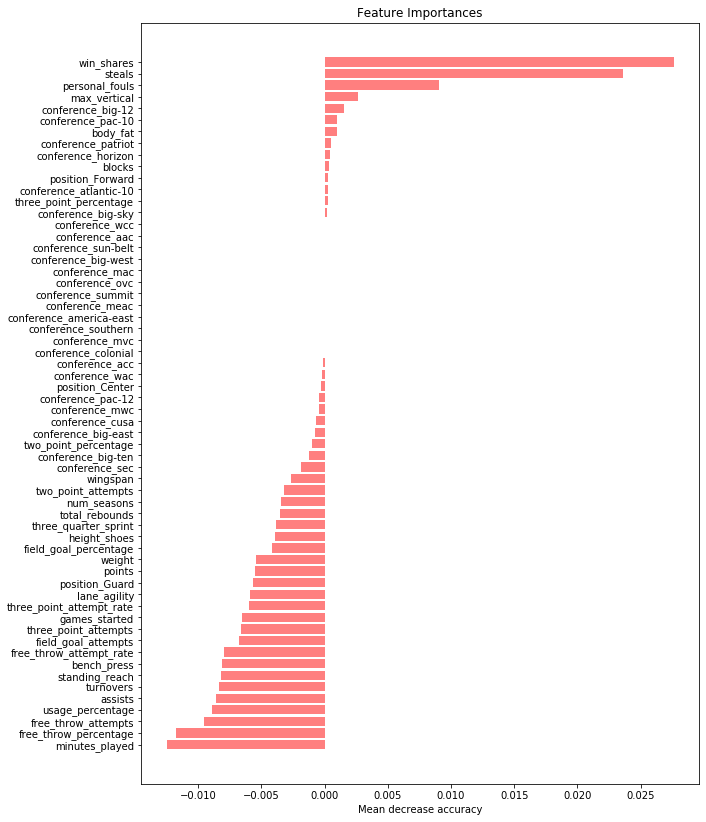

In [12]:
# plot feature testing results
plt.figure(figsize = (10,14))
plt.title('Feature Importances')
plt.barh(range(len(mda_indices)), [mda_importance[i] for i in mda_indices], color='red', alpha = 0.5, align='center')
plt.yticks(range(len(mda_indices)), [mda_features[i] for i in mda_indices])
plt.xlabel('Mean decrease accuracy')
plt.show()